# Synthetic Dataset #1

The dataset is generated as follows:

$$x_i, \dots, x_k \sim \mathcal{N}(\mu_j, \Sigma_j)$$

with the following parameters:

$$\mu_1 = \begin{pmatrix}
5 \\
5
\end{pmatrix} \; \Sigma_1 =  \begin{pmatrix}
1.0 & 0.0 \\
0.0 & 2.0
\end{pmatrix}$$

$$\mu_2 = \begin{pmatrix}
-5 \\
5
\end{pmatrix} \; \Sigma_2 =  \begin{pmatrix}
0.5 & -0.2 \\
-0.2 & 1.0
\end{pmatrix}$$

$$\mu_3 = \begin{pmatrix}
-5 \\
-5
\end{pmatrix} \; \Sigma_3 =  \begin{pmatrix}
1.0 & 0.0 \\
0.0 & 0.5
\end{pmatrix}$$

$$\mu_4 = \begin{pmatrix}
5 \\
-5
\end{pmatrix} \; \Sigma_4 =  \begin{pmatrix}
1 & 0.5 \\
0.5 & 0.5
\end{pmatrix}$$

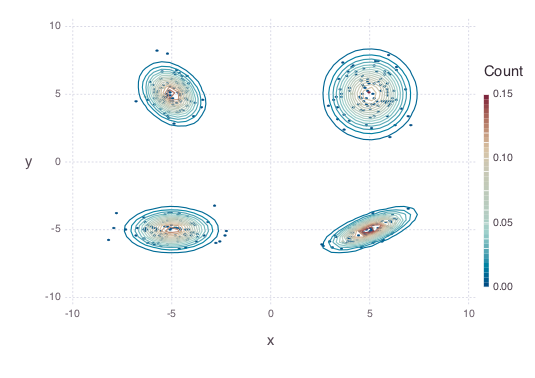

In [1]:
using Gadfly, Distributions

X = rand(MultivariateNormal([5.0, 5.0], [1.0 0.0; 0.0 2.0]), 100) # 1
X = cat(2, X, rand(MultivariateNormal([-5.0, 5.0], [0.5 -0.2; -0.2 1.0]), 100)) # 2
X = cat(2, X, rand(MultivariateNormal([-5.0, -5.0], [1.0 0.0; 0.0 0.5]), 100)) # 3
X = cat(2, X, rand(MultivariateNormal([5.0, -5.0], [1.0 0.5; 0.5 0.5]), 100)) # 4


plot(

layer(z=(x,y) -> pdf(MultivariateNormal([5.0, 5.0], [1.0 0.0; 0.0 2.0]), [x; y]),
     x=linspace(-10,10), y=linspace(-10,10), Geom.contour),
layer(z=(x,y) -> pdf(MultivariateNormal([-5.0, 5.0], [0.5 -0.2; -0.2 1.0]), [x; y]),
     x=linspace(-10,10), y=linspace(-10,10), Geom.contour),
layer(z=(x,y) -> pdf(MultivariateNormal([-5.0, -5.0], [1.0 0.0; 0.0 0.5]), [x; y]),
     x=linspace(-10,10), y=linspace(-10,10), Geom.contour),
layer(z=(x,y) -> pdf(MultivariateNormal([5.0, -5.0], [1.0 0.5; 0.5 0.5]), [x; y]),
     x=linspace(-10,10), y=linspace(-10,10), Geom.contour),

layer(x=X[1,:], y=X[2,:], Geom.hexbin),
Coord.Cartesian(ymin=-10,ymax=10, xmin=-10, xmax=10)
)


# Define SPN base measure

In [2]:
using SPN, BNP

In [3]:
(D, N) = size(X)

μ0 = vec( mean(X, 2) )
κ0 = 1.0
ν0 = convert(Float64, D)
Ψ = eye(D) * 100

G0 = GaussianWishart(μ0, κ0, ν0, Ψ)

μ0 = vec( mean(X, 1) )
κ0 = 1.0
ν0 = convert(Float64, N)
Ψ = eye(N) * 100

G0Mirror = GaussianWishart(μ0, κ0, ν0, Ψ)

# create SPN
root = SumNode(0, scope = collect(1:D))
dist = MultivariateNode{ConjugatePostDistribution}(BNP.add_data(G0, X), collect(1:D))
add!(root, dist)

# create Assignments
assign = Assignments(N)
for i in collect(1:N)
    assign!(assign, i, root)
    assign!(assign, i, dist)
end

increment!(assign, root, i = N)
increment!(assign, dist, i = N)

println(" * - Assignments on Root: ", assign(root))
println(" * - Assignments on Leaf: ", assign(dist))

println("finished initialisation")

 * - Assignments on Root: 400
 * - Assignments on Leaf: 400
finished initialisation


## draw initial configuration

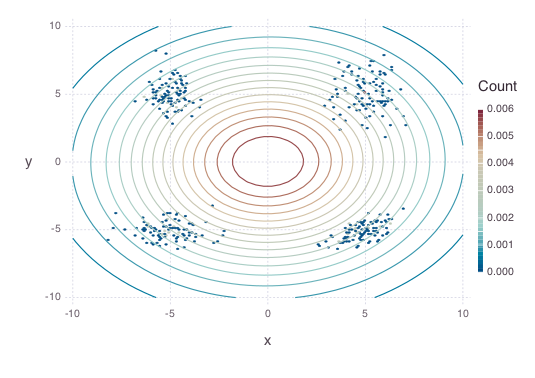

In [4]:
plot(

layer(z=(x,y) -> exp(llh(root, [x; y])[1]),
     x=linspace(-10,10), y=linspace(-10,10), Geom.contour),
layer(x=X[1,:], y=X[2,:], Geom.hexbin),
Coord.Cartesian(ymin=-10,ymax=10, xmin=-10, xmax=10)
)

## run collapsed Gibbs iteration

In [5]:
for i in collect(1:10)
    println(" * - Iteration #", i)
    gibbs_iteration!(root, assign, G0, G0Mirror, X)
    println(" * - Recompute weights")
    SPN.update_weights(root, assign)
    println(" * - LLH: ", llh(root, X)[1])
end

 * - Iteration #1
 * - Recompute weights
 * - LLH: -2440.036001297509
 * - Iteration #2
 * - Recompute weights
 * - LLH: -2440.063747931751
 * - Iteration #3
 * - Recompute weights
 * - LLH: -2440.036001297509
 * - Iteration #4
 * - Recompute weights
 * - LLH: -7783.988417307714
 * - Iteration #5
 * - Recompute weights
 * - LLH: -6652.762871115802
 * - Iteration #6
 * - Recompute weights
 * - LLH: -7783.988417307714
 * - Iteration #7
 * - Recompute weights
 * - LLH: -7783.988417307714
 * - Iteration #8
 * - Recompute weights
 * - LLH: -7783.988417307714
 * - Iteration #9
 * - Recompute weights
 * - LLH: -7013.207259679827
 * - Iteration #10
 * - Recompute weights
 * - LLH: -7783.988417307714


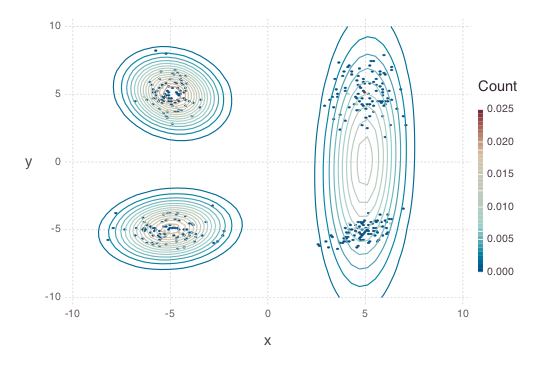

In [6]:
plot(

layer(z=(x,y) -> exp(llh(root, [x; y])[1]),
     x=linspace(-10,10), y=linspace(-10,10), Geom.contour),
layer(x=X[1,:], y=X[2,:], Geom.hexbin),
Coord.Cartesian(ymin=-10,ymax=10, xmin=-10, xmax=10)
)

# Synthetic Dataset #2 (Flower Dataset)

(Text from "The Infinite Mixture of Infinite Gaussian Mixtures")
We generated a flower-shaped two-dimensional artificial data set using a different Gaussian mixture model for each of the four different parts (petals, stem, and two leaves) of the flower.  Each part is considered as a separate cluster. Although covariance matrices are same for all Gaussian components within a mixture they do differ between mixtures to create clusters of different shapes. Petals are formed by a mixture of nine Gaussians sharing a spherical
covariance. Stem is formed by a mixture of four Gaussians sharing a diagonal covariance. Each leaf is formed by a mixture of two Gaussians sharing a full covariance. There are a total of seventeen Gaussian components, four clusters, and 17,000 instances (1000 instances per component) in this data set.

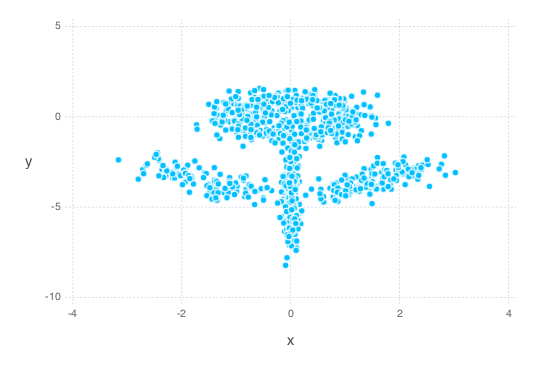

In [32]:
using MAT

vars = matread("NIPS14_flower.mat")
X = vars["X"]'

(D, N) = size(X)

VisualizationSet = rand(1:N,1000)

plot(x = X[1,VisualizationSet], y = X[2,VisualizationSet])